# Telecom company customer churn forecast

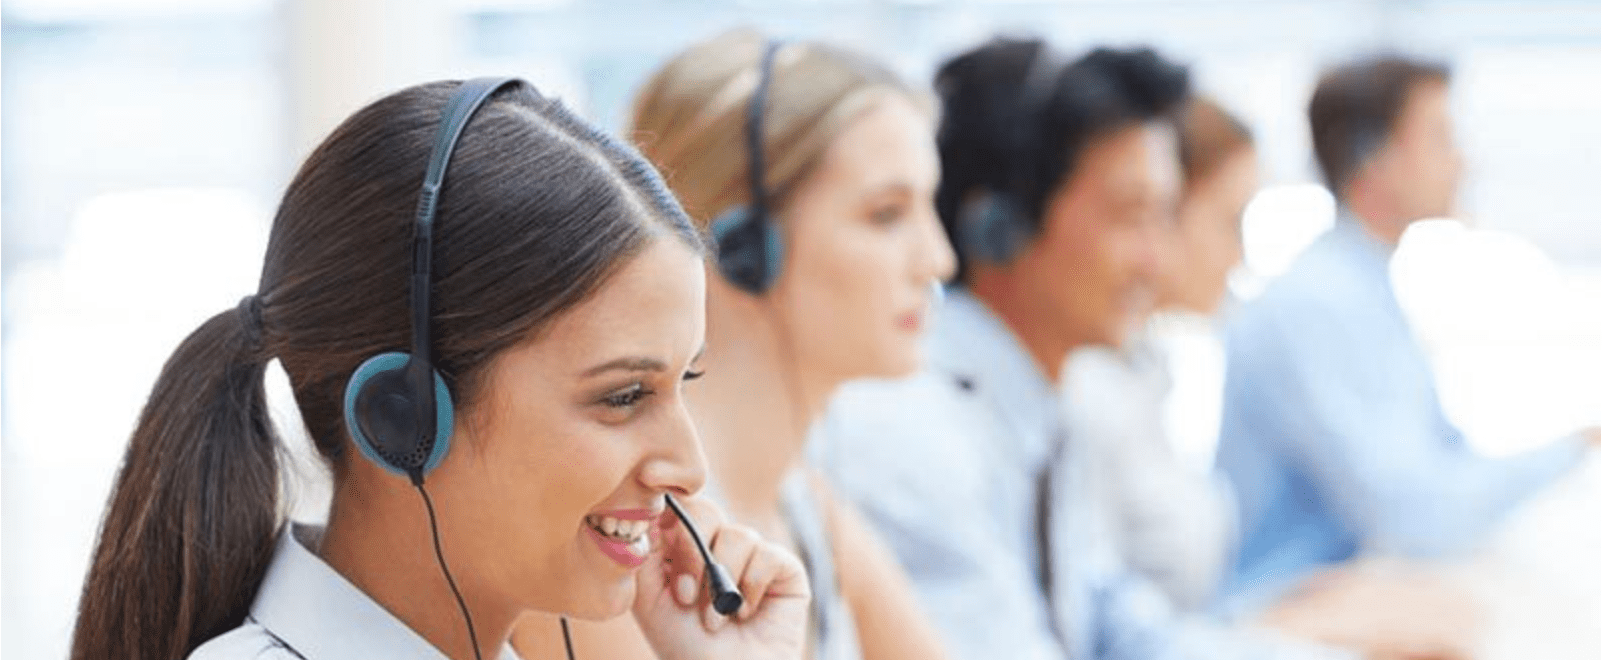

A telecom operator wants to learn how to predict customer churn. If it turns out that the user plans to leave, he will be offered promotional codes and special conditions. The operator's team collected personal data about some customers, information about their tariffs and contracts.

**Description of services** 

The operator provides two main types of services:
1. Fixed telephone connection. It is possible to connect a telephone set to several lines at the same time.
2. Internet. The connection can be of two types: via a telephone line (DSL, from the English digital subscriber line, “digital subscriber line”) or fiber optic cable (Fiber optic).

**The following services are also available:**

- Internet security: antivirus (DeviceProtection) and blocking of unsafe sites (OnlineSecurity);
- Dedicated technical support line (TechSupport);
- Cloud file storage for data backup (OnlineBackup);
- Streaming television (StreamingTV) and catalog of films (StreamingMovies).
Clients can pay for services every month or sign a contract for 1-2 years. Various payment methods and the possibility of receiving an electronic check are available.

**Data Description** 

The data consists of files obtained from different sources:
- contract.csv — information about the contract;
- personal.csv — client's personal data;
- internet.csv - information about Internet services;
- phone.csv — information about telephony services.

In all files, the customerID column contains the customer ID.
**Information on contracts is current as of February 1, 2020.**

## Data preparation

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import statsmodels.api as sm

In [2]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import warnings
warnings.filterwarnings("ignore")
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, accuracy_score, classification_report
from lightgbm import LGBMClassifier
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [3]:
contract = pd.read_csv('/datasets/final_provider/contract.csv')
personal = pd.read_csv('/datasets/final_provider/personal.csv')
internet = pd.read_csv('/datasets/final_provider/internet.csv')
phone = pd.read_csv('/datasets/final_provider/phone.csv')

### Exploring Files

#### Contract Information

In [4]:
contract.info()
contract.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


**Summary:**
- **BeginDate** - start date of services provision (should be changed to date format).
- **EndDate** - end date of services provision. If the date is missing, then the client continues to use the services (should be changed to the date format).
- **Type** - Subscription type. Clients can pay for services every month or sign a contract for 1-2 years.
- **PaperlessBilling** - The service of receiving an electronic check. Connected - yes. No - not connected.
- **PaymentMethod** - Payment type.
- **MonthlyCharges** - Monthly payment for an individual customer.
- **TotalCharges** - Total charges for the entire time of use (not a suitable format for the presented data, you need to check the contents of the column). 

In [5]:
contract['TotalCharges'].describe()

count     7043
unique    6531
top           
freq        11
Name: TotalCharges, dtype: object

11 rows with missing values, they must either be removed or replaced.

In [6]:
contract[contract['TotalCharges'] == ' ']

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
488,4472-LVYGI,2020-02-01,No,Two year,Yes,Bank transfer (automatic),52.55,
753,3115-CZMZD,2020-02-01,No,Two year,No,Mailed check,20.25,
936,5709-LVOEQ,2020-02-01,No,Two year,No,Mailed check,80.85,
1082,4367-NUYAO,2020-02-01,No,Two year,No,Mailed check,25.75,
1340,1371-DWPAZ,2020-02-01,No,Two year,No,Credit card (automatic),56.05,
3331,7644-OMVMY,2020-02-01,No,Two year,No,Mailed check,19.85,
3826,3213-VVOLG,2020-02-01,No,Two year,No,Mailed check,25.35,
4380,2520-SGTTA,2020-02-01,No,Two year,No,Mailed check,20.00,
5218,2923-ARZLG,2020-02-01,No,One year,Yes,Mailed check,19.70,
6670,4075-WKNIU,2020-02-01,No,Two year,No,Mailed check,73.35,


Since all these clients have just arrived, we can replace the passes with the cost of one month of using the servic

In [7]:
contract['TotalCharges'] = np.where(contract['TotalCharges'] == ' ', 
                                    contract['MonthlyCharges'], contract['TotalCharges'])

In [8]:
contract['TotalCharges'] = contract['TotalCharges'].astype(float)

#### Client's personal data

In [9]:
personal.info()
personal.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


**Summary:**
- **gender** - sex.
- **SeniorCitizen** - an elderly person. (?)
- **Partner** - the presence of a partner. Spouse or spouses.
- **Dependents** - Dependents. It's most likely about children.

#### Internet service information

In [10]:
internet.info()
internet.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


**Summary:**
- **InternetService** - Internet service. Connection can be of two types: through a telephone line (DSL, from the English digital subscriber line, "digital subscriber line") or fiber optic cable (Fiber optic).
- **OnlineSecurity** - Unsafe websites blocking service.
- **OnlineBackup** - Cloud file storage for data backup.
- **DeviceProtection** - Antivirus service is connected.
- **TechSupport** - Dedicated technical support line service is connected.
- **StreamingTV** - Streaming TV service is connected.
- **StreamingMovies** - The service of watching movies from the catalog is connected.

#### Information about telephony services

In [11]:
phone.info()
phone.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


**Резюме:**  
- **MultipleLines** - Connecting a telephone set to several lines at the same time.

### Conclusion
Churn forecasting is a classic classification problem. To solve this problem, you need to create a column with a target feature. This can be done based on the column EndDate - the end date of the provision of services. If the date is missing, then the client continues to use the services. Lines with "No" will be replaced with 2020-02-01 (the last actual date). After that, we will create a **StoppedUs** column, where 1 - the client has left, 0 - continues to use the services.
The provided files contain information about 7043 clients. The number of clients using the Internet and the telephone differ from the total numbers, which means that not all clients use both services, but choose one of them for themselves.

## Data analysis

Let's create a start table with a target feature.

In [12]:
contract['StoppedUs'] = (contract['EndDate'] != 'No').astype(int)

In [13]:
contract['EndDate'] = contract['EndDate'].replace({'No':'2020-02-01'})

In [14]:
contract['BeginDate'] = pd.to_datetime(contract['BeginDate'], format='%Y-%m-%d')
contract['EndDate'] = pd.to_datetime(contract['EndDate'], format='%Y-%m-%d')
contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,StoppedUs
0,7590-VHVEG,2020-01-01,2020-02-01,Month-to-month,Yes,Electronic check,29.85,29.85,0
1,5575-GNVDE,2017-04-01,2020-02-01,One year,No,Mailed check,56.95,1889.50,0
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,1
3,7795-CFOCW,2016-05-01,2020-02-01,One year,No,Bank transfer (automatic),42.30,1840.75,0
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,1


Since the models are poorly trained on dates, we will create separate columns where we calculate how many months and days the client has used or is using the company's services as of February 1, 2020. After that, the columns **BeginDate**, **EndDate** can be deleted.

In [15]:
contract['Months'] = ((contract.EndDate - contract.BeginDate)/np.timedelta64(1, 'M')).round()
contract['Days'] = ((contract.EndDate - contract.BeginDate)/np.timedelta64(1, 'D'))
contract = contract.drop(['BeginDate','EndDate'],axis=1)
contract.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,StoppedUs,Months,Days
0,7590-VHVEG,Month-to-month,Yes,Electronic check,29.85,29.85,0,1.0,31.0
1,5575-GNVDE,One year,No,Mailed check,56.95,1889.50,0,34.0,1036.0
2,3668-QPYBK,Month-to-month,Yes,Mailed check,53.85,108.15,1,2.0,61.0
3,7795-CFOCW,One year,No,Bank transfer (automatic),42.30,1840.75,0,45.0,1371.0
4,9237-HQITU,Month-to-month,Yes,Electronic check,70.70,151.65,1,2.0,61.0


### Customer churn analysis

In [16]:
print('Number of clients who left: {:.2%}'.format(
                                   contract[contract['StoppedUs']==1].StoppedUs.count()/contract.shape[0]))
print('Number of remaining clients: {:.2%}'.format(
                                   contract[contract['StoppedUs']==0].StoppedUs.count()/contract.shape[0]))

Number of clients who left: 26.54%
Number of remaining clients: 73.46%


It is necessary to determine the reasons for the outflow of almost two thousand customers.

### Monthly customer churn analysis

In [17]:
contract['Months'].describe()

count    7043.000000
mean       32.371149
std        24.559481
min         0.000000
25%         9.000000
50%        29.000000
75%        55.000000
max        72.000000
Name: Months, dtype: float64

The average length of time a client uses services before leaving is about 30 months. For a complete picture of what is happening, let's plot the distribution of the duration of contracts by the outflow of customers.

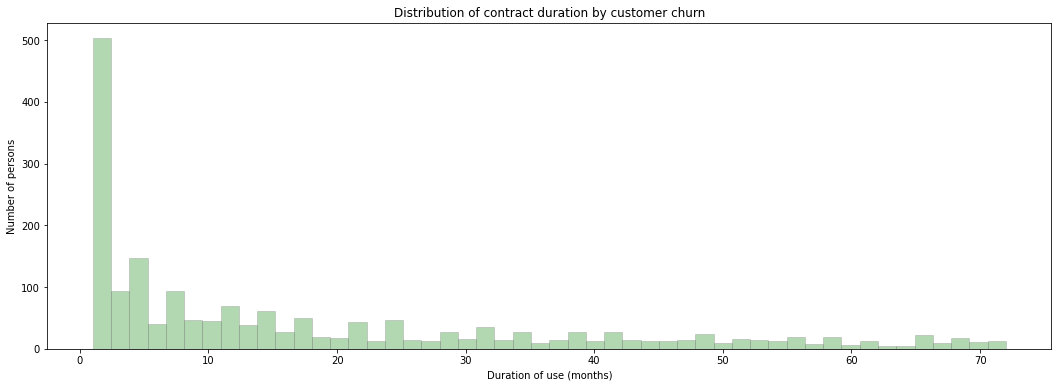

In [18]:
plt.figure(figsize=(18, 6))
plt.hist(contract[contract['StoppedUs'] == 1].Months, bins=50, color='green', edgecolor='grey', alpha=0.3)
plt.title('Distribution of contract duration by customer churn')
plt.xlabel('Duration of use (months)')
plt.ylabel('Number of persons')
plt.show()

A large proportion of customers leave almost immediately after the start of use. Which raises doubts about the high quality of the services provided. It is also possible that there are external factors that need to be dealt with at the beginning of the client's journey.

### Analysis of the outflow of customers by the cost of services per month

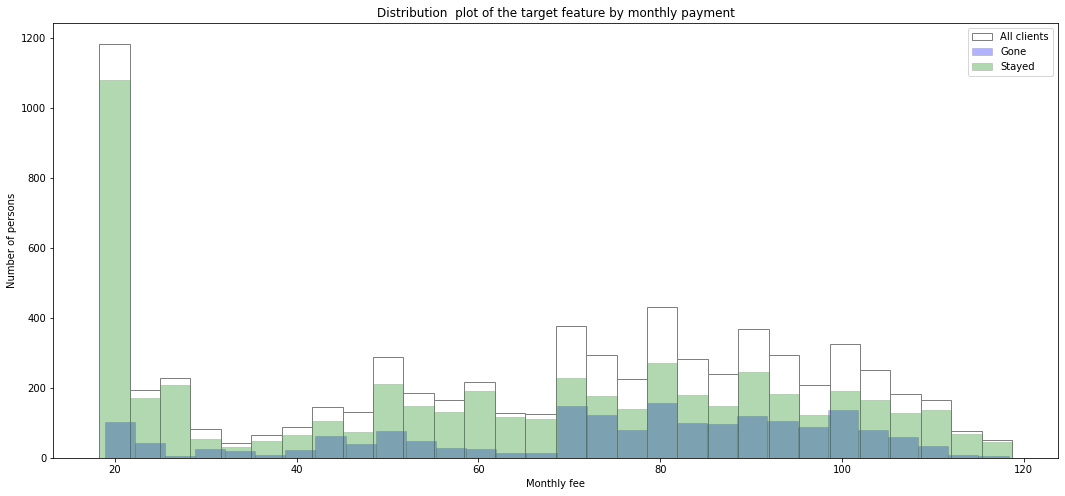

In [19]:
plt.figure(figsize=(18,8))
plt.hist(contract['MonthlyCharges'], 
                  bins=30, color='white', edgecolor='grey', alpha=1, label = 'All clients')
plt.hist(contract[contract['StoppedUs']==1].MonthlyCharges,
                  bins=30, color='blue', edgecolor='grey', alpha=0.3, label = 'Gone')
plt.hist(contract[contract['StoppedUs']==0].MonthlyCharges,
                  bins=30, color='green', edgecolor='grey', alpha=0.3, label = 'Stayed')
plt.title('Distribution  plot of the target feature by monthly payment')
plt.xlabel('Monthly fee')
plt.ylabel('Number of persons')
plt.legend()
plt.show()

Just after the threshold of 70, the percentage of customers who leave in relation to the remaining customers increases dramatically. This suggests that clients are not ready to pay such money for the services provided in this budget. Or competitors offer better conditions for the same money. It is necessary to analyze their proposals and draw appropriate conclusions.

### Merging tables

For further analysis, it is necessary to combine the provided tables in order to simplify the work with the presented features. We use the **customerID** column for joining.

In [20]:
df_full = contract.merge(personal, on='customerID',how='outer')
df_full = df_full.merge(internet, on='customerID',how='outer')
df_full = df_full.merge(phone, on='customerID',how='outer')

In [21]:
df_full.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   Type              7043 non-null   object 
 2   PaperlessBilling  7043 non-null   object 
 3   PaymentMethod     7043 non-null   object 
 4   MonthlyCharges    7043 non-null   float64
 5   TotalCharges      7043 non-null   float64
 6   StoppedUs         7043 non-null   int64  
 7   Months            7043 non-null   float64
 8   Days              7043 non-null   float64
 9   gender            7043 non-null   object 
 10  SeniorCitizen     7043 non-null   int64  
 11  Partner           7043 non-null   object 
 12  Dependents        7043 non-null   object 
 13  InternetService   5517 non-null   object 
 14  OnlineSecurity    5517 non-null   object 
 15  OnlineBackup      5517 non-null   object 
 16  DeviceProtection  5517 non-null   object 


Replace all missing values from the internet and phone tables with 'No'

In [22]:
df_full = df_full.fillna('No')

To increase the speed of the future model, we will replace all the values "Yes" with 0, "No" with 1.

In [23]:
df_full = df_full.replace('Yes', 0).replace('No', 1)

In [24]:
df_full.head()

,customerID,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,StoppedUs,Months,Days,gender,...,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,Month-to-month,0,Electronic check,29.85,29.85,0,1.0,31.0,Female,...,0,1,DSL,1,0,1,1,1,1,1
1,5575-GNVDE,One year,1,Mailed check,56.95,1889.50,0,34.0,1036.0,Male,...,1,1,DSL,0,1,0,1,1,1,1
2,3668-QPYBK,Month-to-month,0,Mailed check,53.85,108.15,1,2.0,61.0,Male,...,1,1,DSL,0,0,1,1,1,1,1
3,7795-CFOCW,One year,1,Bank transfer (automatic),42.30,1840.75,0,45.0,1371.0,Male,...,1,1,DSL,0,1,0,0,1,1,1
4,9237-HQITU,Month-to-month,0,Electronic check,70.70,151.65,1,2.0,61.0,Female,...,1,1,Fiber optic,1,1,1,1,1,1,1


### Multi-coleniality

The results of the churn analysis for services can be similar to each other. In order not to overload the future model, we will check all features for multicolleniarity and remove duplicate features if necessary. To do this, we use the VIF (Variance Inflation Factors) function.

In [25]:
def get_VIF(dataFrame,target):
    X=sm.add_constant(dataFrame.loc[:,dataFrame.columns != target])
    seriesObject = pd.Series([variance_inflation_factor(X.values,i) for i in range(X.shape[1])],index=X.columns)
    return seriesObject
target = 'StoppedUs'
dataFrame= df_full.drop(['customerID','InternetService','gender','Type','PaymentMethod'], axis=1)
print(get_VIF(dataFrame,target))

const                   83.255727
PaperlessBilling         1.177499
MonthlyCharges           5.004155
TotalCharges            10.276646
Months              854223.621772
Days                854141.060017
SeniorCitizen            1.133218
Partner                  1.460002
Dependents               1.370656
OnlineSecurity           1.319032
OnlineBackup             1.429956
DeviceProtection         1.504709
TechSupport              1.362527
StreamingTV              1.830290
StreamingMovies          1.827128
MultipleLines            1.525961
dtype: float64


It is obvious that the month and day columns are highly correlated, one of them can be neglected. We will also remove the column with the largest VIF, this is TotalCharges. It also correlates with MonthlyCharges. We no longer need the customerID column.

In [26]:
df_full = df_full.drop(['TotalCharges','customerID','Months'], axis=1)

In [27]:
df_full.head()

,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,StoppedUs,Days,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,Month-to-month,0,Electronic check,29.85,0,31.0,Female,0,0,1,DSL,1,0,1,1,1,1,1
1,One year,1,Mailed check,56.95,0,1036.0,Male,0,1,1,DSL,0,1,0,1,1,1,1
2,Month-to-month,0,Mailed check,53.85,1,61.0,Male,0,1,1,DSL,0,0,1,1,1,1,1
3,One year,1,Bank transfer (automatic),42.30,0,1371.0,Male,0,1,1,DSL,0,1,0,0,1,1,1
4,Month-to-month,0,Electronic check,70.70,1,61.0,Female,0,1,1,Fiber optic,1,1,1,1,1,1,1


### Conclusion
The data is ready for further analysis.

## Построение модели оттока клиентов

The team leader was tasked with building a customer churn model. The client will leave in the foreseeable future or will not leave (binary classification). The main criterion for the success of our model is the ROC-AUC indicator. The performance evaluation criteria are presented below:
- AUC-ROC < 0.75 — 0 sp
- 0.75 ≤ AUC-ROC < 0.81 — 4 sp
- 0.81 ≤ AUC-ROC < 0.85 — 4.5 sp
- 0.85 ≤ AUC-ROC < 0.87 — 5 sp
- 0.87 ≤ AUC-ROC < 0.88 — 5.5 sp
- AUC-ROC ≥ 0.88 — 6 sp

To solve this problem, we will use the lightGBM gradient boosting model, which does an excellent job of solving this type of problem. First, let's transform all the categorical features.

In [28]:
data = df_full
numerical = data.select_dtypes(['number']).columns
categorical = data.columns.difference(numerical)
data[categorical] = data[categorical].astype('category')

Let's form test and training samples.

In [29]:
X = data.drop(['StoppedUs'],axis=1)
y = data['StoppedUs']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .2, random_state = 12345)

In [30]:
model_lgbm = LGBMClassifier(random_state = 12345)
model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)
y_pred_lgbm_train = model_lgbm.predict(X_train)
y_proba_log = model_lgbm.predict_proba(X_test)[:, 1]
lgbm_test_as = accuracy_score(y_pred_lgbm, y_test)
lgbm_train_as = accuracy_score(y_pred_lgbm_train, y_train)

print(f"LGBM accuracy on the test set {lgbm_test_as}")
print(f"LGBM accuracy on the training set {lgbm_train_as}")
print("LGBM roc_auc on test:", roc_auc_score(y_test,y_proba_log))

LGBM accuracy on the test set 0.8488289567068843
LGBM accuracy on the training set 0.9155129570465034
LGBM roc_auc on test: 0.891695058534211


Next, I will improve our model by identifying the most useful features for our model (feautures importants).

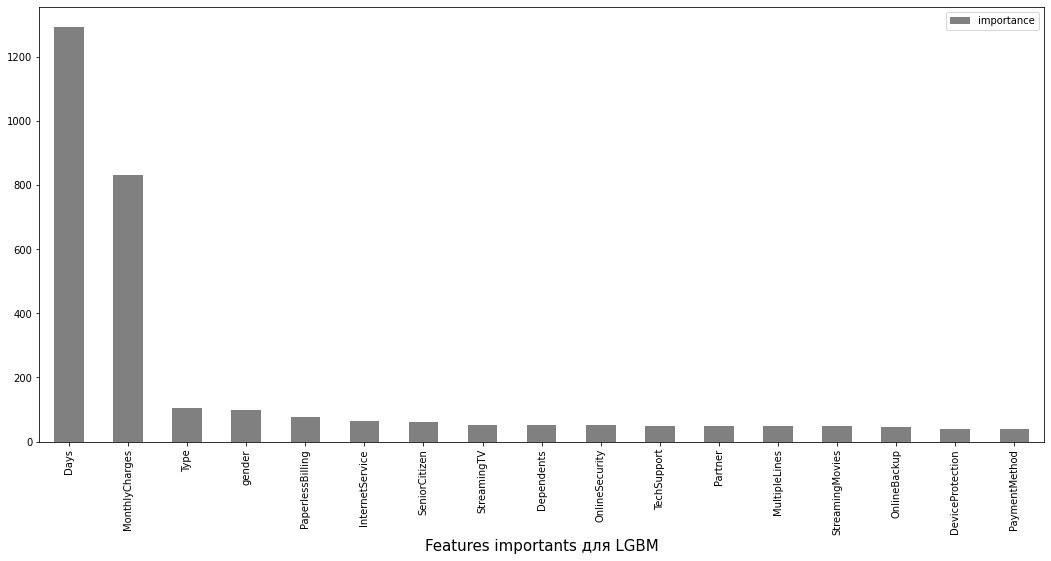

In [31]:
feature_importance_ = pd.DataFrame({'importance' : model_lgbm.feature_importances_}, index = X.columns)

feature_importance_.sort_values(by = 'importance', 
                                ascending = False, axis = 0)[:].plot(kind = 'bar', color = 'grey', figsize = (18, 8))
plt.xlabel("Features importants для LGBM", 
                                fontdict= {"fontsize" : 15});

Having identified five main features, we will try to build a model only on them.

In [32]:
FI = data[['Days','MonthlyCharges','Type','gender','TechSupport']]

In [33]:
X_train, X_test, y_train, y_test = train_test_split(FI, y, test_size = .2, random_state = 42)

In [34]:
model_lgbm = LGBMClassifier(random_state = 12345)
model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)
y_pred_lgbm_train = model_lgbm.predict(X_train)
y_proba_log = model_lgbm.predict_proba(X_test)[:, 1]
lgbm_test_as = accuracy_score(y_pred_lgbm, y_test)
lgbm_train_as = accuracy_score(y_pred_lgbm_train, y_train)

print(f"LGBM accuracy on the test set {lgbm_test_as}")
print(f"LGBM accuracy on the training set {lgbm_train_as}")
print("LGBM roc_auc on the test:", roc_auc_score(y_test,y_proba_log))

LGBM accuracy on the test set 0.8772178850248403
LGBM accuracy on the training set 0.901313454029109
LGBM roc_auc on the test: 0.925798596375004


ROC-AUC has improved a lot. Now let's try to play with the parameters of the model.
We use the early_stopping_rounds parameter so that the model stops training if the result does not improve. And a couple of classic options.

In [35]:
fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'auc', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 0,
            'categorical_feature': 'auto'}

We choose the parameters among which the model should determine the best connection.

In [36]:
param_test ={'max_bin':  [10,25,50,75,125,150,200,250],
             'learning_rate' : [0.0001,0.001,0.01,],
             'num_iterations' : [200,400,600,800,1000],
             'num_leaves': sp_randint(6, 50),
             'subsample': sp_uniform(loc=0.2, scale=0.8)}

In [37]:
clf = LGBMClassifier(random_state=12345, n_jobs=-1, n_estimators=50)
gs = RandomizedSearchCV(
    estimator=clf, param_distributions=param_test, 
    n_iter=50,
    scoring='roc_auc',
    cv=5,
    refit=True,
    random_state=12345,
    verbose=True,
    return_train_score = True
)

In [ ]:
gs.fit(X_train, y_train, **fit_params)
print('Best result: {} parameters: {} '.format(gs.best_score_, gs.best_params_))

Fitting 5 folds for each of 50 candidates, totalling 250 fits


In [ ]:
model_lgbm = LGBMClassifier(random_state=12345, n_jobs=-1, **gs.best_params_)

In [ ]:
model_lgbm.fit(X_train, y_train)

y_pred_lgbm = model_lgbm.predict(X_test)
y_pred_lgbm_train = model_lgbm.predict(X_train)
y_proba_log = model_lgbm.predict_proba(X_test)[:, 1]
lgbm_test_as = accuracy_score(y_pred_lgbm, y_test)
lgbm_train_as = accuracy_score(y_pred_lgbm_train, y_train)

print(f"LGBM accuracy on test {lgbm_test_as}")
print(f"LGBM accuracy on train {lgbm_train_as}")
print("LGBM roc_auc on test:", roc_auc_score(y_test,y_proba_log))

It was possible to slightly improve the quality of the model.

## General conclusion

The data was analyzed and processed. Some reasons for customer churn have been identified. Data prepared.
As a result of the choice of parameters for the LGBM model, we obtained the final metrics: AUC-ROC: 0.927 and Accuracy: 0.875.
After analyzing our model, we see that the main attributes that affect customer churn are contract duration, service cost, contract type, customer gender, and maintenance. The remaining services are also important, but do not affect the model as much as the first five. Our model can predict customer churn with 93% probability, and at this stage we need to offer the customer a discount or additional service.